This notebook will derive certain elements of how conic locations and errors are estimated in mirrorfit based on 3D point locations and their associated errors.

In [9]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
sp.init_printing()

# Z-Projection

We start off with projecting our measured onto the conic along the $Z$-axis. This requires us to calculate the $Z$ coordinate from $X$ and $Y$. 

$conz$ will be our equation for the $Z$ value of our conic evaluated at a distance $r=\sqrt{X^2+Y^2}$ from the origin. The symmetry of the conic allows us to use r instead of $X$ and $Y$ individually.

We start off defining symbols we'll use to describe the conics as well as some assumptions we make about them:

In [192]:
k,R = sp.symbols('k R', real=True)
r = sp.symbols('r', real=True, positive=True)

In [193]:
c=1/R

In [194]:
conz = sp.simplify((c*r**2) / (1 + sp.sqrt(1-(1+k)*c**2*r**2)))

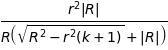

In [195]:
conz

If we say a test point exists at ($X_0$, $Y_0$, $Z_0$), we can now calculate $d_Z$, the $Z$ distance between our point and the conic by evaluating $Z_0 - conz(r)$ but this distance overestimates the distance between the point and the conic. What we do instead is linearize the conic at the $Z$ projection point and then calculate the distance to the plane representing this linearization. 

To linearize we need the gradient of the conic at our evaluation point, which is just $\frac{d conz}{dr}$ again because of symmetry, so the problem is effectively two dimensional:

In [208]:
gradconz = sp.simplify(sp.diff(conz, r))

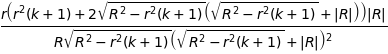

In [209]:
gradconz

To find our minimum distance $d_{min}$ to the linearized plane, we must find the length of the normal vector running from the plane to the point. 

To do this, we can imagine a triangle formed by the slope (gradient) we just calculated as $\frac{rise}{run}$ such that we have our "rise" of $gradconz(r)$ when our "run" is $1$. This triangle is similar to the triangle formed by the $Z$ projection distance from the point to the conic, the normal vector that runs from the linearized plane to the point (which is the minimum distance from the point to the plane), and the line connecting these two that runs along the linearized plane. This gives us a ratio equation involving $d_{min}$:

$$\frac{\sqrt{gradconz^2 + 1}}{1} = \frac{d_Z}{d_{min}}$$

yielding: 

$$d_{min} = \frac{d_Z}{\sqrt{gradconz^2+1}}$$

We can think of this as a scale factor $S$ that we apply to $d_Z$:

$S(r) = \frac{1}{\sqrt{gradconz(r)^2+1}}$

such that finally:

$d_{min}(r) = S(r) d_Z(r)$


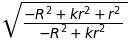

In [210]:
S = sp.symbols('S')
S=sp.sqrt(sp.factor(sp.simplify(1 / (gradconz**2+1))))
S

So we end up with the scale factor as:

$$S = \sqrt{\frac{r^2(k+1)-R^2}{kr^2-R^2}}$$

## Error Analysis

# Radial projection

In [199]:
S2 = sp.sqrt(1 / (gradconz**2+1))

In [204]:
S.subs(k,-.1).subs(R,42).subs(r,100)

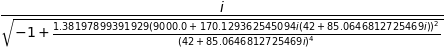

In [203]:
S2.subs(k,-.1).subs(R,42).subs(r,100)

In [207]:
sp.N((S-S2).subs(k,-0.154749).subs(R, -107.4339).subs(r,100))

In [191]:
(sp.sqrt(1/(1+x)) - 1/sp.sqrt(1+x)).subs(x,500)